In [235]:
import importlib
import Config.default_config
import Model.model
import Utils.train_test_utils
importlib.reload(Model.model)
importlib.reload(Config.default_config)
importlib.reload(Utils.train_test_utils)
from Config.default_config import default_cfg
from Utils.train_test_utils import progressive_domain_denoiser
from matplotlib import pyplot as plt
import numpy as np
import Dataset.npz_data_loader as ndl
opt = default_cfg(argv=["--load_option_path",
                        "Config/Mayo-Config/test_progressive_option.json",
                        ])
model = progressive_domain_denoiser(opt,result_save_path="TestSamples")

options are loading...
loading cfg except ['load_option_path']
options were loaded successfully!
save_freq: 8000
batch_size: 1
test_batch_size: 1
max_epochs: 300
init_lr: 0.00015
test_numbers: -1
mode: test_prog
run_name: test_prog_Mayo
model_name: IPDM
device: cuda:0
convertor: ART
load_option_path: Config/Mayo-Config/test_progressive_option.json
load_img_model_path: Pretrained Params/Mayo
load_proj_model_path: Pretrained Params/Mayo
resume_epochs_proj: 20
resume_epochs_img: 20
display_result: True
test_result_data_save: False
benchmark_test: False
metrics: ['psnr', 'ssim', 'fsim', 'vif', 'nqm']
fbp_sharpen: True
ntv: 0
normal: False
ultra_img_denoise: True
in_channels_img: 1
out_channels_img: 1
model_channels_img: 64
attention_resolutions_img: [8, 16]
channel_mult_img: [1, 1, 2, 2, 4, 4]
timesteps_img: 1000
partial_timesteps_img: 50
schedule_power_img: 1
clip_img: True
save_states_img: False
lambda_ratio_img: 10
t_start_img: [15, 15, 15]
eta_img: 0.7
constant_guidance_img: 0.45
kerne

L067 358077819


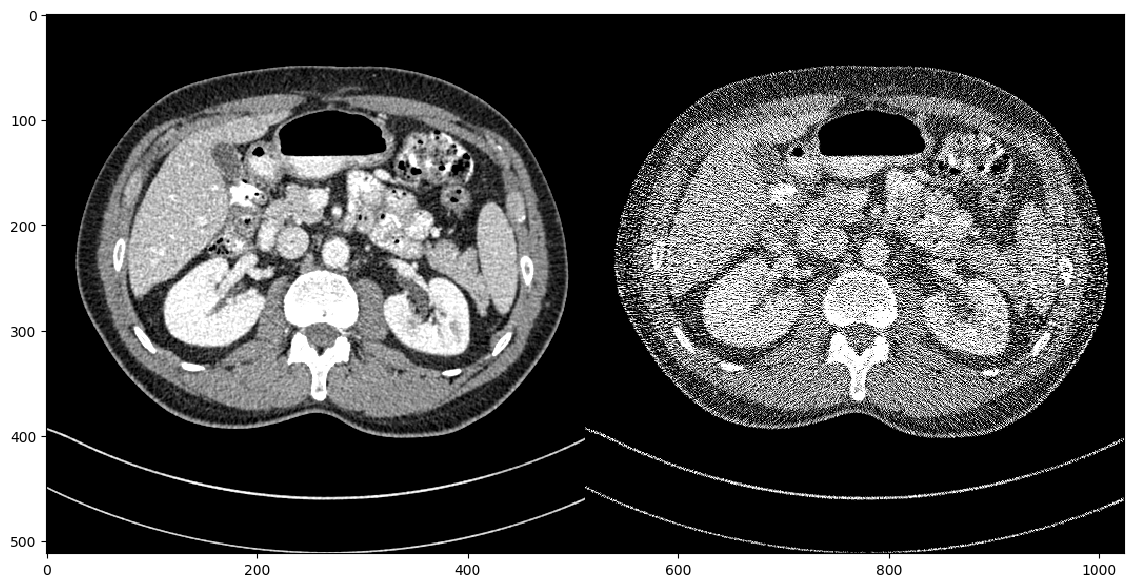

In [236]:
# load data
idx=30
image=model.test_dataset.collate([model.test_dataset[idx]])
ld_img, fd_proj, fd_img, ld_proj = image
model.data_sample_load(ldct=ld_img, ldproj=ld_proj, fdproj=fd_proj, fdct=fd_img)
model.save_path_load(0, model.test_dataset.patient_name[idx], model.test_dataset.slice_name[idx])
plt.figure(figsize=(15,7))
plt.imshow(np.hstack((ndl.miu2pixel(fd_img[0,0].numpy()),model.ldct_np)), cmap = "gray",vmin=(-160+1024)/4096,vmax=(240+1024)/4096)
pn=model.test_dataset.patient_name[idx]
sn=model.test_dataset.slice_name[idx]
print(model.test_dataset.patient_name[idx],model.test_dataset.slice_name[idx])

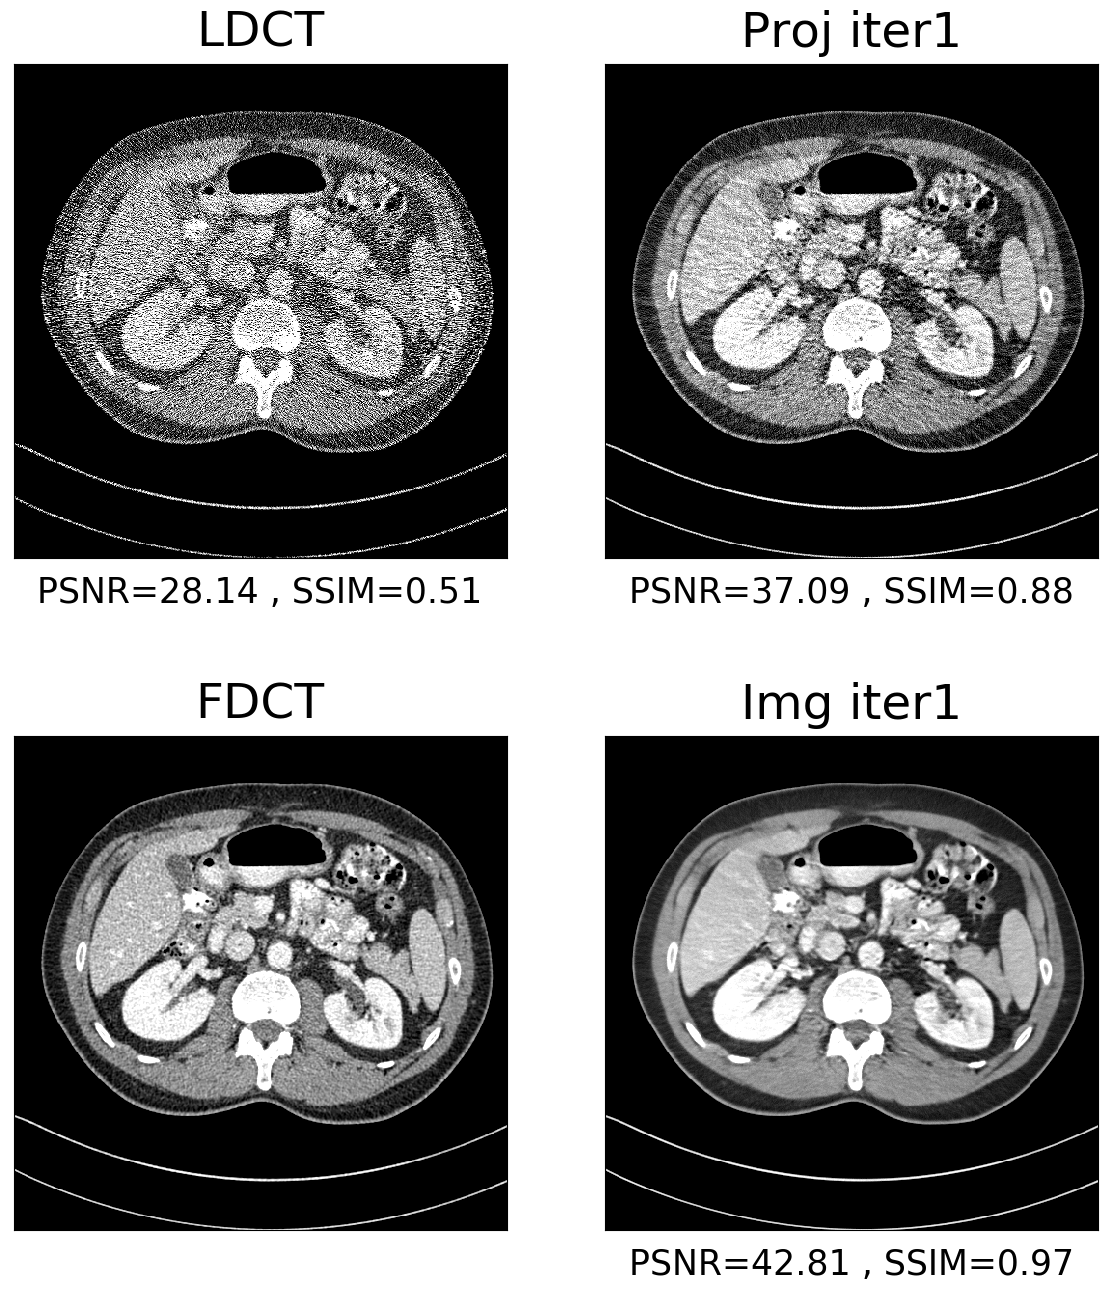

In [239]:
# progressive domain denoising-dense-sampling
model.reset_opt()
model.update_opt(dict(convertor="FBP",save_it_state_img=False,save_it_state_proj=False,ultra_img_denoise=True))
model.temp_clear()
model.progressive_denoiser(sharpen_num=70,save_proj_state=True)
model.result_figure_save(mode="progressive")
model.result_data_save()
model.metric_update()

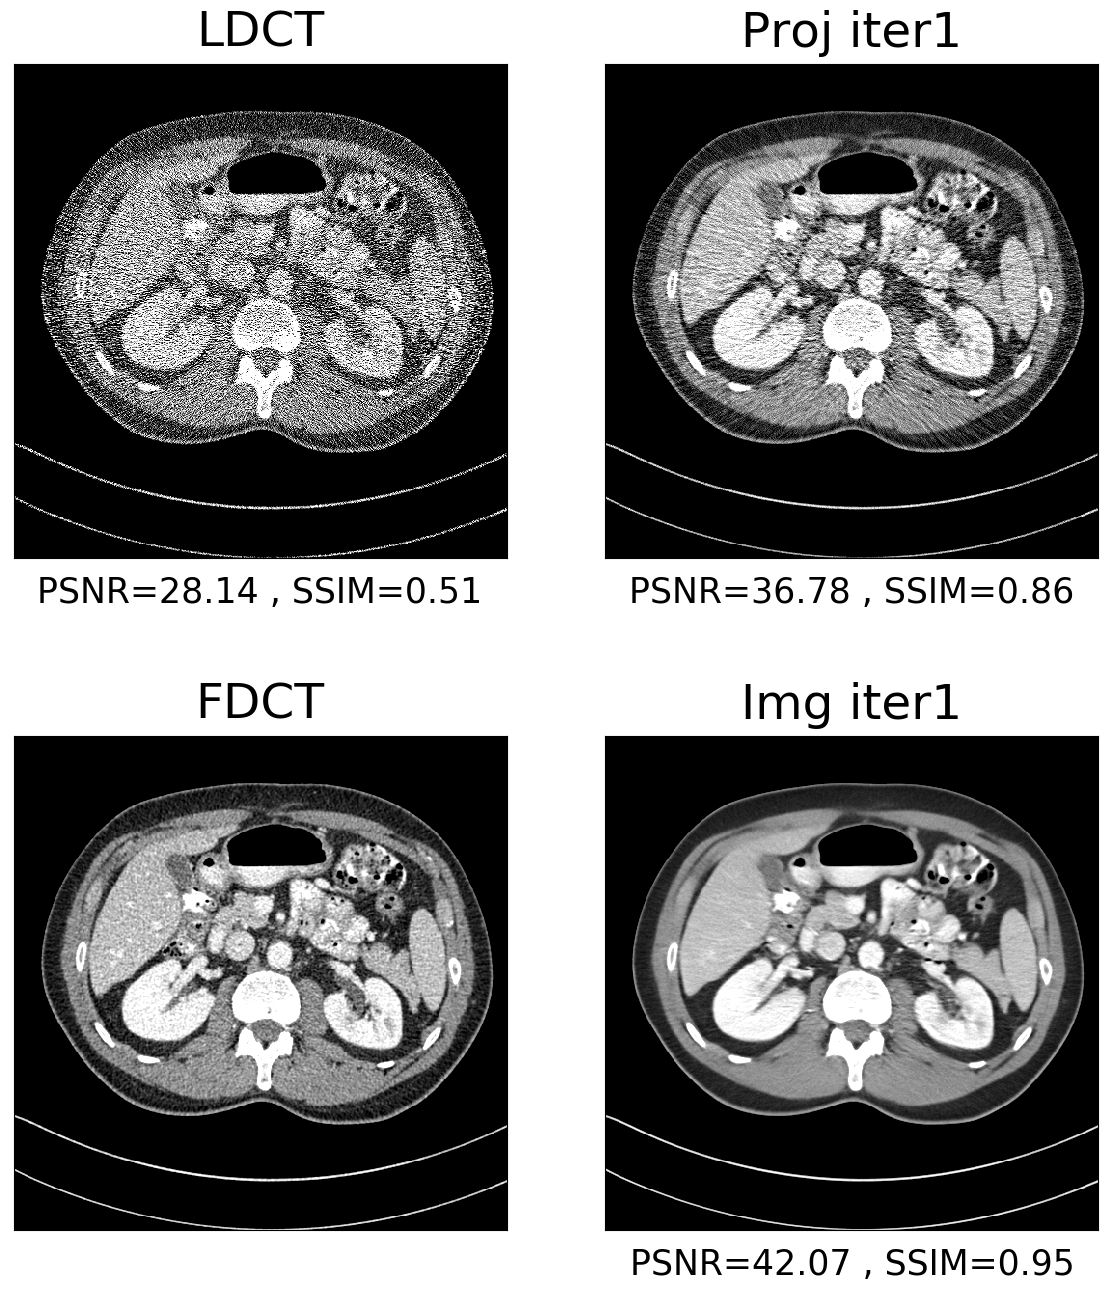

In [238]:
# progressive domain denoising-sparse-sampling
# model.reset_opt()
model.update_opt(dict(convertor="FBP",save_it_state_img=False,t_start_proj=[15,15,5],sample_method_proj='sparse',
                      save_it_state_proj=False,ddim_timesteps_proj=[1,2,3],t_start_img=[18,18,5],ddim_timesteps_img=[1,2,3],sample_method_img="sparse",ultra_img_denoise=True))
model.temp_clear()
_ = model.progressive_denoiser(sharpen_num=70,save_proj_state=True)
model.result_figure_save(mode="progressive")
model.result_data_save()
model.metric_update()

In [ ]:
########################################################################################
##############################Paper Figures Generation###################################
########################################################################################

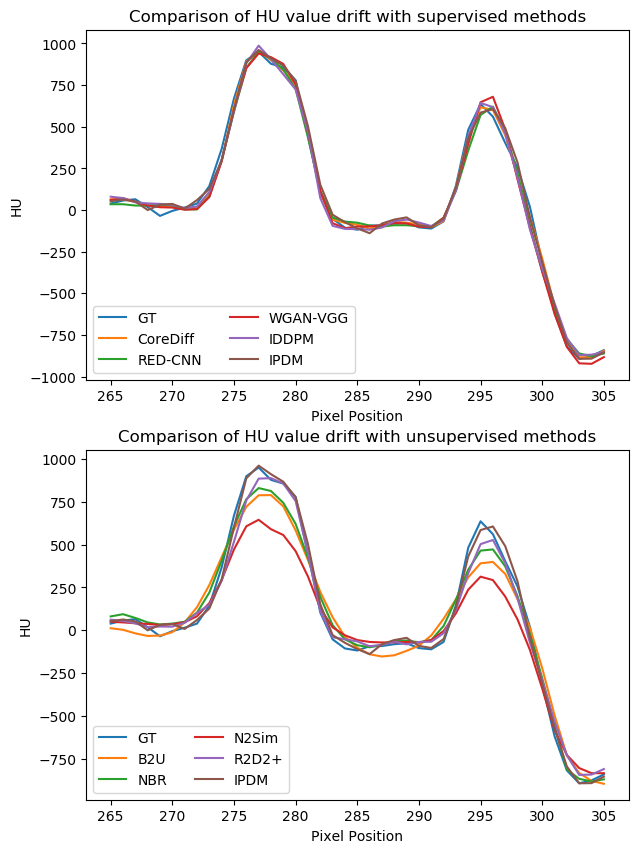

In [146]:
from Dataset.npz_data_loader import miu2HU, pixel2HU,reset_window_centre
# HU Value Drift
row=337
col1=265
col2=306
t=np.arange(col1,col2)
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
HU_GT=pixel2HU(model.fdct).astype(int)[row,col1:col2]
plt.plot(t,HU_GT)
HU_core=miu2HU(np.load(r"F:\mayo\test\denoise_result\core_diff\L067\358074963.npy")[0]).astype(int)[row,col1:col2]
plt.plot(t,HU_core)
HU_red=miu2HU(np.load(r"F:\mayo\test\denoise_result\redcnn\L067\358074963.npy")[0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_red)
HU_wgan=miu2HU(np.load(r"F:\mayo\test\denoise_result\wgan\L067\358074963.npy")[0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_wgan)

HU_dpm=pixel2HU(np.load(r"I:\ddpm_mayo\denoise result\ddpm20xs_60\L067\358074963.npy")[0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_dpm)

# HU_TV=miu2HU(np.load(r'ModelTrainLog/IPDM_test_TV_Mayo/2024-04-02T10-56-58/save_test_results/Save_Iter_0/L067/358074963/proj_denoise_result_2img.npz')['iter_1'][0,0]).astype(int)[row,col1:col2]
# plt.plot(t,HU_TV)
ipdm=np.load('E:\Liaofeiyang\ddpm_host\models\diffusion_models\TestSamples\IPDM_test_prog_Mayo_Lesion\save_test_results/Save_Iter_0/L067/358074963/img_denoise_result.npz')
HU_ipdm=miu2HU(ipdm[ipdm.files[-1]][0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_ipdm)
plt.legend(['GT','CoreDiff','RED-CNN','WGAN-VGG','IDDPM','IPDM'],ncol=2,prop = {'size':10})
plt.xlabel('Pixel Position')
plt.ylabel('HU')
plt.title('Comparison of HU value drift with supervised methods')
plt.subplot(2,1,2)
HU_GT=pixel2HU(model.fdct).astype(int)[row,col1:col2]
plt.plot(t,HU_GT)
HU_b2u=miu2HU(np.load(r"F:\mayo\test\denoise_result\b2u\L067\358074963.npy")[0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_b2u)
HU_nbr=miu2HU(np.load(r"F:\mayo\test\denoise_result\nbr\L067\358074963.npy")[0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_nbr)
HU_n2s=pixel2HU(np.load(r"I:\ddpm_mayo\denoise result\N2Sim\L067\358074963.npy")).astype(int)[row,col1:col2]
plt.plot(t,HU_n2s)
HU_R2D2=miu2HU(np.load(r'E:\Liaofeiyang\ddpm_host\models\diffusion_models\ModelTrainLog/IPDM_test_R2D2_Mayo/2024-03-22T12-46-54/save_test_results/Save_Iter_0/L067/358074963/img_denoise_result.npz')['iter_1'][0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_R2D2)
# HU_ipdm=miu2HU(np.load('TestSamples/IPDM_test_prog_Mayo_Lesion/save_test_results/Save_Iter_0/L067/358074963/img_denoise_result.npz')['iter_3'][0,0]).astype(int)[row,col1:col2]
plt.plot(t,HU_ipdm)
plt.legend(['GT','B2U','NBR','N2Sim','R2D2+','IPDM'],ncol=2,prop = {'size':10})
plt.xlabel('Pixel Position')
plt.ylabel('HU')
plt.title('Comparison of HU value drift with unsupervised methods')
plt.savefig('HU Drift.png',ddpi=50)

In [ ]:
import json
from Dataset.npz_data_loader import miu2HU, pixel2HU,reset_window_centre,miu2pixel
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
from scipy.ndimage import zoom
# lesion result mayo
win=[-160,240]
p=pn
s=sn
r=dict()
m=dict()
r['GT']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p,s)[2].numpy()),win)[0]
roi = cv2.selectROI('roi', r['GT'], False, False )
cv2.waitKey(0)
cv2.destroyAllWindows()

dr=1

r['FBP']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p,s)[0].numpy()),win)[0]
m['FBP']=[psnr(r['GT'],r['FBP'],data_range=dr),ssim(r['GT'],r['FBP'],win=11,data_range=dr)]

r['RED-CNN']=reset_window_centre(miu2pixel(np.load(r"G:\mayo\test\denoise_result\redcnn\{}\{}.npy".format(p,s))),win)[0,0]
m['RED-CNN']=[psnr(r['GT'],r['RED-CNN'],data_range=dr),ssim(r['GT'],r['RED-CNN'],win=11,data_range=dr)]

r['WGAN-VGG']=reset_window_centre(miu2pixel(np.load(r"G:\mayo\test\denoise_result\wgan\{}\{}.npy".format(p,s))),win)[0,0]
m['WGAN-VGG']=[psnr(r['GT'],r['WGAN-VGG'],data_range=dr),ssim(r['GT'],r['WGAN-VGG'],win=11,data_range=dr)]

r['CoreDiff']=reset_window_centre(miu2pixel(np.load(r"G:\mayo\test\denoise_result\core_diff\{}\{}.npy".format(p,s))),win)[0]
m['CoreDiff']=[psnr(r['GT'],r['CoreDiff'],data_range=dr),ssim(r['GT'],r['CoreDiff'],win=11,data_range=dr)]

r['IDDPM']=reset_window_centre(np.load(r"G:\mayo\test\denoise_result\ddpm20xs_60\{}\{}.npy".format(p,s)),win)[0,0]
m['IDDPM']=[psnr(r['GT'],r['IDDPM'],data_range=dr),ssim(r['GT'],r['IDDPM'],win=11,data_range=dr)]

r['ARW-TV']=reset_window_centre(miu2pixel(np.load('ModelTrainLog/IPDM_test_TV_Mayo/2024-04-02T10-56-58/save_test_results/Save_Iter_0/{}/{}/proj_denoise_result_2img.npz'.format(p,s))['iter_1'][0,0]),win).copy()
m['ARW-TV']=[psnr(r['GT'],r['ARW-TV'],data_range=dr),ssim(r['GT'],r['ARW-TV'],win=11,data_range=dr)]

r['B2U']=reset_window_centre(miu2pixel(np.load(r"G:\mayo\test\denoise_result\b2u\{}\{}.npy".format(p,s))),win)[0,0]
m['B2U']=[psnr(r['GT'],r['B2U'],data_range=dr),ssim(r['GT'],r['B2U'],win=11,data_range=dr)]

r['NBR']=reset_window_centre(miu2pixel(np.load(r"G:\mayo\test\denoise_result\nbr\{}\{}.npy".format(p,s))),win)[0,0]
m['NBR']=[psnr(r['GT'],r['NBR'],data_range=dr),ssim(r['GT'],r['NBR'],win=11,data_range=dr)]

r['N2Sim']=reset_window_centre(np.load(r"G:\mayo\test\denoise_result\N2Sim\{}\{}.npy".format(p,s)),win)
m['N2Sim']=[psnr(r['GT'], r['N2Sim'], data_range=dr), ssim(r['GT'], r['N2Sim'], win=11, data_range=dr)]

r['R2D2+']=reset_window_centre(miu2pixel(np.load('ModelTrainLog/IPDM_test_R2D2_Mayo/2024-03-22T12-46-54/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(p,s))['iter_1'][0,0]),win)
m['R2D2+']=[psnr(r['GT'],r['R2D2+'],data_range=dr),ssim(r['GT'],r['R2D2+'],win=11,data_range=dr)]

ipdm=np.load('TestSamples/IPDM_test_prog_Mayo_Lesion/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(p,s))
r['IPDM']=reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)
m['IPDM']=[psnr(r['GT'],r['IPDM'],data_range=dr),ssim(r['GT'],r['IPDM'],win=11,data_range=dr)]

os.makedirs(r'C:\Users\15647\Desktop\lesion\mayo\{}\{}'.format(p,s),exist_ok=True)

img_all=np.zeros((512*2,512*6,3))
for step,key in enumerate(r):   
    img=cv2.cvtColor(r[key], cv2.COLOR_GRAY2RGB)
    img=(img*255).astype(np.uint8)
    if key!='GT':
        cv2.putText(img, 'PSNR:{}'.format(format(m[key][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(img, 'SSIM:{}'.format(format(m[key][1],'.4f')), (5,40 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.rectangle(img, (int(roi[0]), int(roi[1])), (int(roi[0]+roi[3]), int(roi[1]+roi[3])), (0,0,255), 1)
    img_roi=img[int(roi[1]):int(roi[1]+roi[3])+1,int(roi[0]):int(roi[0]+roi[3])+1,:].astype(np.uint8)
    if step == 0:
        sub_roi = cv2.selectROI('roi2', img_roi, False, False )
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    cv2.rectangle(img_roi, (int(sub_roi[0]), int(sub_roi[1])), (int(sub_roi[0]+sub_roi[3]), int(sub_roi[1]+sub_roi[3])), (255,0,0), 1)
    img_roi=zoom(img_roi,(512*2/(5*img_roi.shape[0]),512*2/(5*img_roi.shape[0]),1))
    img[512-img_roi.shape[0]:,:][:,512-img_roi.shape[0]:]=img_roi
    cv2.imwrite(r'C:\Users\15647\Desktop\lesion\mayo\{}\{}\{}.png'.format(p,s,key),img,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
    img_all[(step//6)*512:(1+(step//6))*512,(step%6)*512:(1+(step%6))*512]=img

cv2.imwrite(r'C:\Users\15647\Desktop\lesion\mayo\{}\{}\ALL.png'.format(p,s),img_all,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
info_json = json.dumps(m, sort_keys=False, indent=4, separators=(',', ': '))
f = open(r'C:\Users\15647\Desktop\lesion\mayo\{}\{}\metric.json'.format(p,s), 'w')
f.write(info_json)
f.close()
    

In [ ]:
import json
from Dataset.npz_data_loader import miu2HU, pixel2HU,reset_window_centre,miu2pixel
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
from scipy.ndimage import zoom
# lesion result siemens
win=[-160,240]
# win=[-1024,3072]
p='P00727386'
s='AAAAAAD3'
r=dict()
m=dict()
r['GT']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p,s)[2].numpy()),win)[0]
roi = cv2.selectROI('roi', r['GT'], False, False )
cv2.waitKey(0)
dr=1
cv2.destroyAllWindows()
r['FBP']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p,s)[0].numpy()),win)[0]
m['FBP']=[psnr(r['GT'],r['FBP'],data_range=dr),ssim(r['GT'],r['FBP'],win=11,data_range=dr)]

r['RED-CNN']=reset_window_centre(miu2pixel(np.load(r"F:\siemens\test\denoise_result\redcnn\{}\{}.npy".format(p,s))),win)[0,0]
m['RED-CNN']=[psnr(r['GT'],r['RED-CNN'],data_range=dr),ssim(r['GT'],r['RED-CNN'],win=11,data_range=dr)]

r['WGAN-VGG']=reset_window_centre(miu2pixel(np.load(r"F:\siemens\test\denoise_result\wgan\{}\{}.npy".format(p,s))),win)[0,0]
m['WGAN-VGG']=[psnr(r['GT'],r['WGAN-VGG'],data_range=dr),ssim(r['GT'],r['WGAN-VGG'],win=11,data_range=dr)]

r['CoreDiff']=reset_window_centre(np.load(r"F:\siemens\test\denoise_result\core_diff\{}\{}.npy".format(p,s)),win)[0,0]
m['CoreDiff']=[psnr(r['GT'],r['CoreDiff'],data_range=dr),ssim(r['GT'],r['CoreDiff'],win=11,data_range=dr)]

r['IDDPM']=reset_window_centre(np.load(r"F:\siemens\test\denoise_result\ddpm20xs_60\{}\{}.npy".format(p,s)),win)[0,0]
m['IDDPM']=[psnr(r['GT'],r['IDDPM'],data_range=dr),ssim(r['GT'],r['IDDPM'],win=11,data_range=dr)]

r['ARW-TV']=reset_window_centre(miu2pixel(np.load('ModelTrainLog/IPDM_test_TV_Siemens/2024-04-02T12-44-20/save_test_results/Save_Iter_0/{}/{}/proj_denoise_result_2img.npz'.format(p,s))['iter_1'][0,0]),win).copy()
m['ARW-TV']=[psnr(r['GT'],r['ARW-TV'],data_range=dr),ssim(r['GT'],r['ARW-TV'],win=11,data_range=dr)]

r['B2U']=reset_window_centre(miu2pixel(np.load(r"F:\siemens\test\denoise_result\b2u\{}\{}.npy".format(p,s))),win)[0,0]
m['B2U']=[psnr(r['GT'],r['B2U'],data_range=dr),ssim(r['GT'],r['B2U'],win=11,data_range=dr)]

r['NBR']=reset_window_centre(miu2pixel(np.load(r"F:\siemens\test\denoise_result\nbr\{}\{}.npy".format(p,s))),win)[0,0]
m['NBR']=[psnr(r['GT'],r['NBR'],data_range=dr),ssim(r['GT'],r['NBR'],win=11,data_range=dr)]

r['N2Sim']=reset_window_centre(np.load(r"F:\siemens\test\denoise_result\N2Sim\{}\{}.npy".format(p,s)),win)
m['N2Sim']=[psnr(r['GT'], r['N2Sim'], data_range=dr), ssim(r['GT'], r['N2Sim'], win=11, data_range=dr)]

r['R2D2+']=reset_window_centre(miu2pixel(np.load('ModelTrainLog/IPDM_test_R2D2_Siemens/2024-03-22T15-39-45/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(p,s))['iter_1'][0,0]),win)
m['R2D2+']=[psnr(r['GT'],r['R2D2+'],data_range=dr),ssim(r['GT'],r['R2D2+'],win=11,data_range=dr)]

ipdm=np.load(r'E:\Liaofeiyang\DDPM\siemens_test\denoise_result\ddpm\prog_select/{}/{}/prog_denoise_result.npz'.format(p,s))
# ipdm=np.load(r'TestSamples/IPDM_test_prog_Siemens_Lesion/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(p,s))
r['IPDM']=reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)
m['IPDM']=[psnr(r['GT'],r['IPDM'],data_range=dr),ssim(r['GT'],r['IPDM'],win=11,data_range=dr)]

os.makedirs(r'C:\Users\15647\Desktop\lesion\siemens\{}\{}'.format(p,s),exist_ok=True)

img_all=np.zeros((512*2,512*6,3))
for step,key in enumerate(r):   
    img=cv2.cvtColor(r[key], cv2.COLOR_GRAY2RGB)
    img=(img*255).astype(np.uint8)
    if key!='GT':
        cv2.putText(img, 'PSNR:{}'.format(format(m[key][0],'.4f')), (5,25 ), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(img, 'SSIM:{}'.format(format(m[key][1],'.4f')), (5,55 ), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.rectangle(img, (int(roi[0]), int(roi[1])), (int(roi[0]+roi[3]), int(roi[1]+roi[3])), (0,0,255), 1)
    img_roi=img[int(roi[1]):int(roi[1]+roi[3])+1,int(roi[0]):int(roi[0]+roi[3])+1,:].astype(np.uint8)
    if step == 0:
        sub_roi = cv2.selectROI('roi2', img_roi, False, False )
        cv2.waitKey(0)
    
    cv2.rectangle(img_roi, (int(sub_roi[0]), int(sub_roi[1])), (int(sub_roi[0]+sub_roi[2]), int(sub_roi[1]+sub_roi[3])), (255,0,0), 1)
    img_roi=zoom(img_roi,(512*2/(5*img_roi.shape[0]),512*2/(5*img_roi.shape[0]),1))
    # img[512-img_roi.shape[0]:,:][:,512-img_roi.shape[0]:]=img_roi
    # img[512-img_roi.shape[0]:,:][:,0:img_roi.shape[0]]=img_roi
    img[0:img_roi.shape[0],:][:,512-img_roi.shape[0]:]=img_roi
    cv2.imwrite(r'C:\Users\15647\Desktop\lesion\siemens\{}\{}\{}.png'.format(p,s,key),img,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
    img_all[(step//6)*512:(1+(step//6))*512,(step%6)*512:(1+(step%6))*512]=img

cv2.imwrite(r'C:\Users\15647\Desktop\lesion\siemens\{}\{}\ALL.png'.format(p,s),img_all,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
info_json = json.dumps(m, sort_keys=False, indent=4, separators=(',', ': '))
f = open(r'C:\Users\15647\Desktop\lesion\siemens\{}\{}\metric.json'.format(p,s), 'w')
f.write(info_json)
f.close()
cv2.destroyAllWindows()

In [ ]:
import json
from Dataset.npz_data_loader import miu2HU, pixel2HU, reset_window_centre, miu2pixel
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# lesion ROI result mayo

p = 'L067'
s = sn
r = dict()
m = dict()
win = [-160, 240]
r['GT'] = reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p, s)[2].numpy()), win)[0]
roi = cv2.selectROI('roi', r['GT'], False, False)
cv2.waitKey(0)
cv2.destroyAllWindows()
# roi_b = cv2.selectROI('roi2', r['GT'], False, False)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# win = [-1024, 3072]
r['GT'] = reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p, s)[2].numpy()), win)[0]
dr = 1


r['FBP'] = reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p, s)[0].numpy()), win)[0]
m['FBP'] = [psnr(r['GT'], r['FBP'], data_range=dr), ssim(r['GT'], r['FBP'], win=11, data_range=dr)]

r['RED-CNN'] = \
reset_window_centre(miu2pixel(np.load(r"F:\mayo\test\denoise_result\redcnn\{}\{}.npy".format(p, s))), win)[0, 0]
m['RED-CNN'] = [psnr(r['GT'], r['RED-CNN'], data_range=dr), ssim(r['GT'], r['RED-CNN'], win=11, data_range=dr)]

r['WGAN-VGG'] = \
reset_window_centre(miu2pixel(np.load(r"F:\mayo\test\denoise_result\wgan\{}\{}.npy".format(p, s))), win)[0, 0]
m['WGAN-VGG'] = [psnr(r['GT'], r['WGAN-VGG'], data_range=dr), ssim(r['GT'], r['WGAN-VGG'], win=11, data_range=dr)]

r['CoreDiff'] = \
reset_window_centre(miu2pixel(np.load(r"F:\mayo\test\denoise_result\core_diff\{}\{}.npy".format(p, s))), win)[0]
m['CoreDiff'] = [psnr(r['GT'], r['CoreDiff'], data_range=dr), ssim(r['GT'], r['CoreDiff'], win=11, data_range=dr)]

r['IDDPM'] = reset_window_centre(np.load(r"F:\mayo\test\denoise_result\ddpm20xs_60\{}\{}.npy".format(p, s)), win)[0, 0]
m['IDDPM'] = [psnr(r['GT'], r['IDDPM'], data_range=dr), ssim(r['GT'], r['IDDPM'], win=11, data_range=dr)]

r['ARW-TV'] = reset_window_centre(miu2pixel(np.load(
    'ModelTrainLog/IPDM_test_TV_Mayo/2024-04-02T10-56-58/save_test_results/Save_Iter_0/{}/{}/proj_denoise_result_2img.npz'.format(
        p, s))['iter_1'][0, 0]), win).copy()
m['ARW-TV'] = [psnr(r['GT'], r['ARW-TV'], data_range=dr), ssim(r['GT'], r['ARW-TV'], win=11, data_range=dr)]

r['B2U'] = reset_window_centre(miu2pixel(np.load(r"F:\mayo\test\denoise_result\b2u\{}\{}.npy".format(p, s))), win)[0, 0]
m['B2U'] = [psnr(r['GT'], r['B2U'], data_range=dr), ssim(r['GT'], r['B2U'], win=11, data_range=dr)]

r['NBR'] = reset_window_centre(miu2pixel(np.load(r"F:\mayo\test\denoise_result\nbr\{}\{}.npy".format(p, s))), win)[0, 0]
m['NBR'] = [psnr(r['GT'], r['NBR'], data_range=dr), ssim(r['GT'], r['NBR'], win=11, data_range=dr)]

r['N2Sim'] = reset_window_centre(np.load(r"F:\mayo\test\denoise_result\N2Sim\{}\{}.npy".format(p, s)), win)
m['N2Sim'] = [psnr(r['GT'], r['N2Sim'], data_range=dr), ssim(r['GT'], r['N2Sim'], win=11, data_range=dr)]

r['R2D2+'] = reset_window_centre(miu2pixel(np.load(
    'ModelTrainLog/IPDM_test_R2D2_Mayo/2024-03-22T12-46-54/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(
        p, s))['iter_1'][0, 0]), win)
m['R2D2+'] = [psnr(r['GT'], r['R2D2+'], data_range=dr), ssim(r['GT'], r['R2D2+'], win=11, data_range=dr)]

ipdm = np.load(
    'TestSamples/IPDM_test_prog_Mayo_Lesion/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(p, s))
r['IPDM'] = reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0, 0], win)
m['IPDM'] = [psnr(r['GT'], r['IPDM'], data_range=dr), ssim(r['GT'], r['IPDM'], win=11, data_range=dr)]

# calculate roi PSNR/SSIM

PSNR=dict()
SSIM=dict()
img_f_gt=r['GT'][int(roi[1]):int(roi[1]+roi[3])+1,int(roi[0]):int(roi[0]+roi[2])+1]
for key,img in r.items():
    if key == 'GT':
        continue
    img_f=img[int(roi[1]):int(roi[1]+roi[3])+1,int(roi[0]):int(roi[0]+roi[2])+1]
    PSNR[key]=psnr(img_f,img_f_gt, data_range=1)
    SSIM[key]=ssim(img_f,img_f_gt, win=11,data_range=1)


In [ ]:
for k,v in PSNR.items():
    print("{}:{}".format(k,format(v,'.2f')))

In [ ]:
for k,v in SSIM.items():
    print("{}:{}".format(k,format(v,'.4f')))   

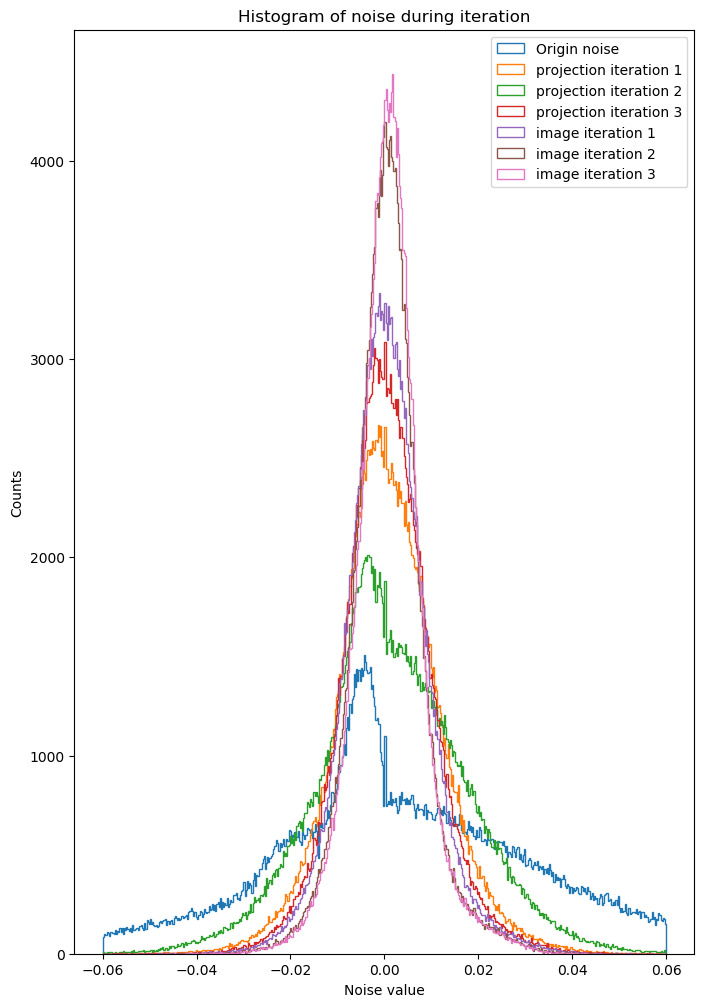

In [171]:
from Dataset.npz_data_loader import miu2pixel
# noise hist
noise=[]
i=0
for (k,v) in model.proj_denoise_convert2img_result.items():
    noise.append(miu2pixel(v[0,0])-model.fdct)
for (k,v) in model.progressive_denoise_result.items():
    noise.append(miu2pixel(v[0,0])-model.fdct)  
del noise[3],noise[-1]
noise_gt=model.ldct_np-model.fdct
import matplotlib.pyplot as plt
# plt.hist(np.ravel(noise[7]),bins=100)
plt.figure(figsize=(8,12))
k1=plt.hist(np.ravel(noise_gt),bins=500,density=False,histtype='step',range=(-0.06,0.06))
for n in noise:
    _=plt.hist(np.ravel(n),bins=500,density=False,histtype='step',range=(-0.06,0.06))
plt.xlabel('Noise value')
plt.ylabel('Counts')
plt.title('Histogram of noise during iteration')
plt.legend(["Origin noise","projection iteration 1","projection iteration 2","projection iteration 3","image iteration 1","image iteration 2","image iteration 3"])
plt.savefig('Hist of noise.png',ddpi=50)

In [ ]:
# dose ablation
import glob
import json
from Dataset.npz_data_loader import miu2HU, pixel2HU,reset_window_centre,miu2pixel
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
from scipy.ndimage import zoom
# lesion result
win=[-160,240]
p=pn
s=sn
r=dict()
m=dict()
r['GT']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p,s)[2].numpy()),win)[0]
roi = cv2.selectROI('roi', r['GT'], False, False )
cv2.waitKey(0)
cv2.destroyAllWindows()
dr=1
roi2 = cv2.selectROI('roi2', r['GT'], False, False )
cv2.waitKey(0)
cv2.destroyAllWindows()

for dose in ["0.05","0.1","0.15","0.25"]:
    ipdm=np.load(r'TestSamples/IPDM_test_prog_Mayo_{}Dose/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(dose,p,s))
    r[f'IPDM_{dose}']=reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)
    m[f'IPDM_{dose}']=[psnr(r['GT'],r[f'IPDM_{dose}'],data_range=dr),ssim(r['GT'],r[f'IPDM_{dose}'],win=11,data_range=dr)]
    try:
        r[f'FBP_{dose}']=reset_window_centre(miu2pixel(np.load(glob.glob((r"G:\ddpm_mayo\test\{}dose\miu_npz\{}\*{}*".format(dose,p,s)))[0])),win)
    except:
        r[f'FBP_{dose}']=reset_window_centre(miu2pixel(np.load(glob.glob((r"G:\ddpm_mayo\test\{}dose\miu_npz\{}\*{}*".format(dose,p,s)))[0])['arr_0']),win)
    m[f'FBP_{dose}']=[psnr(r['GT'],r[f'FBP_{dose}'],data_range=dr),ssim(r['GT'],r[f'FBP_{dose}'],win=11,data_range=dr)]



os.makedirs(r'C:\Users\15647\Desktop\lesion\mayo_dose_ablation\{}\{}'.format(p,s),exist_ok=True)

img_all=np.zeros((512,128*4+512,3))
#GT   
gt=r['GT']
gt=cv2.cvtColor(gt, cv2.COLOR_GRAY2RGB)
gt=(gt*255).astype(np.uint8)
cv2.rectangle(gt, (int(roi[0]), int(roi[1])), (int(roi[0]+roi[3]), int(roi[1]+roi[3])), (0,0,255), 1)
cv2.rectangle(gt, (int(roi2[0]), int(roi2[1])), (int(roi2[0]+roi2[3]), int(roi2[1]+roi2[3])), (255,0,0), 1)
img_roi1=gt[int(roi[1]):int(roi[1]+roi[3])+1,int(roi[0]):int(roi[0]+roi[3])+1,:].astype(np.uint8)
img_roi2=gt[int(roi2[1]):int(roi2[1]+roi2[3])+1,int(roi2[0]):int(roi2[0]+roi2[3])+1,:].astype(np.uint8)
img_roi1=zoom(img_roi1,(512/(4*img_roi1.shape[0]),512/(4*img_roi1.shape[0]),1))
img_roi2=zoom(img_roi2,(512/(4*img_roi2.shape[0]),512/(4*img_roi2.shape[0]),1))
# upper right
gt[0:img_roi1.shape[0],:][:,512-img_roi1.shape[0]:]=img_roi1
# bottom right
gt[512-128-img_roi2.shape[0]:-128,:][:,512-img_roi2.shape[0]:]=img_roi2
img_all[:,0:512]=gt

for step,d in enumerate(["0.05","0.1","0.15","0.25"]):      
    img=r[f'IPDM_{d}']
    img=cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img=(img*255).astype(np.uint8)
    img_roi1=img[int(roi[1]):int(roi[1]+roi[3])+1,int(roi[0]):int(roi[0]+roi[3])+1,:].astype(np.uint8)
    img_roi2=img[int(roi2[1]):int(roi2[1]+roi2[3])+1,int(roi2[0]):int(roi2[0]+roi2[3])+1,:].astype(np.uint8)
    img_roi1=zoom(img_roi1,(512/(4*img_roi1.shape[0]),512/(4*img_roi1.shape[0]),1))
    img_roi2=zoom(img_roi2,(512/(4*img_roi2.shape[0]),512/(4*img_roi2.shape[0]),1))
    img_all[0:128,512+step*128:512+(1+step)*128]=img_roi1
    img_all[256:256+128,512+step*128:512+(1+step)*128]=img_roi2
    
    
    img=r[f'FBP_{d}']
    img=cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img=(img*255).astype(np.uint8)
    img_roi1=img[int(roi[1]):int(roi[1]+roi[3])+1,int(roi[0]):int(roi[0]+roi[3])+1,:].astype(np.uint8)
    img_roi2=img[int(roi2[1]):int(roi2[1]+roi2[3])+1,int(roi2[0]):int(roi2[0]+roi2[3])+1,:].astype(np.uint8)
    img_roi1=zoom(img_roi1,(512/(4*img_roi1.shape[0]),512/(4*img_roi1.shape[0]),1))
    img_roi2=zoom(img_roi2,(512/(4*img_roi2.shape[0]),512/(4*img_roi2.shape[0]),1))
    img_all[128:256,512+step*128:512+(1+step)*128]=img_roi1
    img_all[256+128:512,512+step*128:512+(1+step)*128]=img_roi2
   

cv2.imwrite(r'C:\Users\15647\Desktop\lesion\mayo_dose_ablation\{}\{}\ALL.png'.format(p,s),img_all,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
# info_json = json.dumps(m, sort_keys=False, indent=4, separators=(',', ': '))
# f = open(r'C:\Users\15647\Desktop\lesion\siemens\{}\{}\metric.json'.format(p,s), 'w')
# f.write(info_json)
# f.close()
cv2.destroyAllWindows()

In [ ]:
glob.glob((r"G:\ddpm_mayo\test\{}dose\miu_npz\{}\*{}*".format(dose,p,s)))

In [ ]:
r"G:\ddpm_mayo\test\{}dose\{}\*{}*".format(dose,p,s)

In [ ]:
def roiSelect(img_, roi_, roi2_=None,pos='left'):
    if img_.ndim==2:
        img_=cv2.cvtColor(img_, cv2.COLOR_GRAY2RGB)
    img_=(img_ * 255).astype(np.uint8)
    cv2.rectangle(img_, (int(roi_[0]), int(roi_[1])), (int(roi_[0] + roi_[3]), int(roi_[1] + roi_[3])), (0, 0, 255), 1)
    img_roi1_= img_[int(roi_[1]):int(roi_[1] + roi_[3]) + 1, int(roi_[0]):int(roi_[0] + roi_[3]) + 1, :].astype(np.uint8)
    img_roi1_=zoom(img_roi1_, (512*2/ (5 * img_roi1_.shape[0]), 512*2/ (5 * img_roi1_.shape[0]), 1))
    if pos == 'left':    
        img_[512  - img_roi1_.shape[0]:, :][:,0: img_roi1_.shape[0]]=img_roi1_
    elif pos == 'right':    
        img_[512  - img_roi1_.shape[0]:, :][:,512-img_roi1_.shape[0]:]=img_roi1_
    if roi2_ is not None:
        cv2.rectangle(img_, (int(roi2_[0]), int(roi2_[1])), (int(roi2_[0] + roi2_[3]), int(roi2_[1] + roi2_[3])), (255, 0, 0), 1)
        img_roi2_= img_[int(roi2_[1]):int(roi2_[1] + roi2_[3]) + 1, int(roi2_[0]):int(roi2_[0] + roi2_[3]) + 1, :].astype(np.uint8)
        img_roi2_=zoom(img_roi2_, (512 / (5 * img_roi2_.shape[0]), 512 / (5 * img_roi2_.shape[0]), 1))
         # bottom right 
        img_[512  - img_roi2_.shape[0]:, :][:, 512 - img_roi1_.shape[0] - img_roi2_.shape[0]:512 - img_roi1_.shape[0]]=img_roi2_
    return img_

In [ ]:
def OnlyroiSelect(img_, roi_, roi2_=None):
    if img_.ndim==2:
        img_=cv2.cvtColor(img_, cv2.COLOR_GRAY2RGB)
    img_=(img_ * 255).astype(np.uint8)
    # cv2.rectangle(img_, (int(roi_[0]), int(roi_[1])), (int(roi_[0] + roi_[3]), int(roi_[1] + roi_[3])), (0, 0, 255), 1)
    img_roi1_= img_[int(roi_[1]):int(roi_[1] + roi_[3]) + 1, int(roi_[0]):int(roi_[0] + roi_[3]) + 1, :].astype(np.uint8)
   
    img_roi1_=zoom(img_roi1_, (512*5/ (5 * img_roi1_.shape[0]), 512*5/ (5 * img_roi1_.shape[0]), 1))
    img_=img_roi1_
    if roi2_ is not None:
        cv2.rectangle(img_, (int(roi2_[0]), int(roi2_[1])), (int(roi2_[0] + roi2_[3]), int(roi2_[1] + roi2_[3])), (255, 0, 0), 1)
        img_roi2_= img_[int(roi2_[1]):int(roi2_[1] + roi2_[3]) + 1, int(roi2_[0]):int(roi2_[0] + roi2_[3]) + 1, :].astype(np.uint8)
        img_roi2_=zoom(img_roi2_, (512 / (5 * img_roi2_.shape[0]), 512 / (5 * img_roi2_.shape[0]), 1))
         # bottom right
        img_[512  - img_roi2_.shape[0]:, :][:, 512 - img_roi1_.shape[0] - img_roi2_.shape[0]:512 - img_roi1_.shape[0]]=img_roi2_
    return img_

In [ ]:
# NFE ablation
r=dict()
m=dict()
r['GT']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(pn,sn)[2].numpy()),win)[0]
roi = cv2.selectROI('roi', r['GT'], False, False )
cv2.waitKey(0)
cv2.destroyAllWindows()
win=[-160,240]
for NFE in ['10','60','100','240']:
    ipdm=np.load(r'TestSamples/IPDM_test_prog_Mayo_NFE{}/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(NFE,pn,sn))
    r[f"IPDM_{NFE}"]= reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)
    m[f"IPDM_{NFE}"]=[psnr(r['GT'],r[f"IPDM_{NFE}"],data_range=dr),ssim(r['GT'],r[f"IPDM_{NFE}"],win=11,data_range=dr)]
for NFE in ['10','60','100','1000']:
    iddpm=np.squeeze(np.load(r'I:\ddpm_mayo\denoise result\ddpm20xs_{}/{}/{}.npy'.format(NFE,pn,sn)))
    r[f"IDDPM_{NFE}"]= reset_window_centre(iddpm,win)
    m[f"IDDPM_{NFE}"]=[psnr(r['GT'],r[f"IDDPM_{NFE}"],data_range=dr),ssim(r['GT'],r[f"IDDPM_{NFE}"],win=11,data_range=dr)]
    
img_all=np.zeros((512*2,512*5,3))
#GT   
gt=r['GT']
gt=roiSelect(gt,roi)
img_all[:512,:512]=gt
# FBP
r['FBP']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(pn,sn)[0].numpy()),win)[0]
m['FBP']=[psnr(r['GT'],r['FBP'],data_range=dr),ssim(r['GT'],r['FBP'],win=11,data_range=dr)]
fbp=roiSelect(r['FBP'],roi)
cv2.putText(fbp, 'PSNR:{}'.format(format(m['FBP'][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
cv2.putText(fbp, 'SSIM:{}'.format(format(m['FBP'][1],'.4f')), (5,40 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
img_all[512:,:512]=fbp

# IPDM 10~240
for step,NFE in enumerate(['10','60','100','240']):  
    IPDM=roiSelect(r[f"IPDM_{NFE}"],roi)
    cv2.putText(IPDM, 'PSNR:{}'.format(format(m[f"IPDM_{NFE}"][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(IPDM, 'SSIM:{}'.format(format(m[f"IPDM_{NFE}"][1],'.4f')), (5,40 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    img_all[:512,(step+1)*512:(step+2)*512]=IPDM
    

# IDDPM 10~1000
for step,NFE in enumerate(['10','60','100','1000']):  
    IDDPM=roiSelect(r[f"IDDPM_{NFE}"],roi)
    cv2.putText(IDDPM, 'PSNR:{}'.format(format(m[f"IDDPM_{NFE}"][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(IDDPM, 'SSIM:{}'.format(format(m[f"IDDPM_{NFE}"][1],'.4f')), (5,40 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    img_all[512:,(step+1)*512:(step+2)*512]=IDDPM

os.makedirs(r'C:\Users\15647\Desktop\lesion\mayo_NFE_ablation\{}\{}'.format(p,s),exist_ok=True)
cv2.imwrite(r'C:\Users\15647\Desktop\lesion\mayo_NFE_ablation\{}\{}\ALL.png'.format(p,s),img_all,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])


In [ ]:
# condition ablation
r=dict()
m=dict()
r['GT']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(pn,sn)[2].numpy()),win)[0]
roi = cv2.selectROI('roi', r['GT'], False, False )
cv2.waitKey(0)
cv2.destroyAllWindows()

roi2 = cv2.selectROI('roi2', r['GT'], False, False )
cv2.waitKey(0)
cv2.destroyAllWindows()

win=[-160,240]
img_all=np.zeros((512*4,512*3,3))
#GT   
gt=r['GT']
gt=roiSelect(gt,roi,roi2)
img_all[:512,:512]=gt

# FBP
r['FBP']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(pn,sn)[0].numpy()),win)[0]
m['FBP']=[psnr(r['GT'],r['FBP'],data_range=dr),ssim(r['GT'],r['FBP'],win=11,data_range=dr)]
fbp=roiSelect(r['FBP'],roi,roi2)
cv2.putText(fbp, 'PSNR:{}'.format(format(m['FBP'][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
cv2.putText(fbp, 'SSIM:{}'.format(format(m['FBP'][1],'.4f')), (5,50 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
img_all[:512,512:512*2]=fbp


for pc in [0.3,0.5,0.7,'None']:
    for ic in [0.3,0.5,0.7,'None']:
        try:
            ipdm=np.load(r'TestSamples/IPDM_test_prog_Mayo_Condition_p{}_i{}/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(pc,ic,pn,sn))
            r[f"IPDM_{pc}_{ic}"]= reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)
            m[f"IPDM_{pc}_{ic}"]=[psnr(r['GT'],r[f"IPDM_{pc}_{ic}"],data_range=dr),ssim(r['GT'],r[f"IPDM_{pc}_{ic}"],win=11,data_range=dr)]
        except:
            pass

# Adaptive
IPDM=roiSelect(r["IPDM_None_None"],roi,roi2)
cv2.putText(IPDM, 'PSNR:{}'.format(format(m["IPDM_None_None"][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
cv2.putText(IPDM, 'SSIM:{}'.format(format(m["IPDM_None_None"][1],'.4f')), (5,50 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
img_all[:512,512*2:3*512]=IPDM



#IPDM condition
for ip,pc in enumerate([0.3,0.5,0.7]):
    for ii,ic in enumerate([0.3,0.5,0.7]):
        IPDM=roiSelect(r[f"IPDM_{pc}_{ic}"],roi,roi2)
        cv2.putText(IPDM, 'PSNR:{}'.format(format(m[f"IPDM_{pc}_{ic}"][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(IPDM, 'SSIM:{}'.format(format(m[f"IPDM_{pc}_{ic}"][1],'.4f')), (5,50 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(IPDM, 'Proj  lambda = {}'.format(pc), (250,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(IPDM, 'Imag lambda = {}'.format(ic), (250,50 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        img_all[(ip+1)*512:(ip+2)*512,ii*512:(ii+1)*512]=IPDM
    
os.makedirs(r'C:\Users\15647\Desktop\lesion\mayo_condition_ablation\{}\{}'.format(p,s),exist_ok=True)
cv2.imwrite(r'C:\Users\15647\Desktop\lesion\mayo_condition_ablation\{}\{}\ALL.png'.format(p,s),img_all,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])


In [ ]:
# real-world LDCT
import json
from Dataset.npz_data_loader import miu2HU, pixel2HU,reset_window_centre,miu2pixel
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
from scipy.ndimage import zoom
win=[-160, 240]
# win=[-1000, 240]
p=pn
s=sn
r=dict()
m=dict()
# r['GT']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(p,s)[2].numpy()),win)[0]

FBP=reset_window_centre(miu2pixel(np.load(r"I:\Siemens\realLd_miu_npz\{}\{}.npy".format(p,s)),win))
# FBP=[psnr(r['GT'],r['FBP'],data_range=dr),ssim(r['GT'],r['FBP'],win=11,data_range=dr)]

roi = cv2.selectROI('roi', FBP, False, False )
cv2.waitKey(0)
dr=1
cv2.destroyAllWindows()

r['RED-CNN']=reset_window_centre(cv2.imread(r"I:\Siemens\realLd_result\redcnn\{}\{}.png".format(p,s))/255,win)

r['WGAN-VGG']=reset_window_centre(cv2.imread(r"I:\Siemens\realLd_result\wgan\{}\{}.png".format(p,s))/255,win)

r['CoreDiff']=reset_window_centre(np.load(r"I:\Siemens\realLd_result\core_diff\{}\{}.npy".format(p,s)),win)[0,0]

r['IDDPM']=reset_window_centre(np.load(r"I:\Siemens\realLd_result\ddpm20xs_60\{}\{}.npy".format(p,s)),win)[0,0]

r['ARW-TV']=reset_window_centre(cv2.imread(r'I:\Siemens\realLd_result\tv\{}\{}.png'.format(p,s))/255,win)

r['B2U']=reset_window_centre(cv2.imread(r"I:\Siemens\realLd_result\b2u\{}\{}.png".format(p,s))/255,win)

r['NBR']=reset_window_centre(cv2.imread(r"I:\Siemens\realLd_result\nbr\{}\{}.png".format(p,s))/255,win)

r['N2Sim']=reset_window_centre(np.load(r"I:\Siemens\realLd_result\N2Sim\{}\{}.npy".format(p,s)),win)

r['R2D2+']=reset_window_centre(miu2pixel(np.load('ModelTrainLog/IPDM_test_R2D2_RealSiemens/2024-05-10T14-20-24/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(p,s))['iter_1'][0,0]),win)

ipdm=np.load(r'TestSamples/IPDM_test_prog_Siemens_Real/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(p,s))
r['IPDM']=reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)


os.makedirs(r'C:\Users\15647\Desktop\lesion\siemens_real\{}\{}'.format(p,s),exist_ok=True)

img_all=np.zeros((512*2,512*6,3))
fbp=OnlyroiSelect(FBP,roi)
img_all[:512,:512]=fbp
img_all[512:2*512,:512]=255
for step,key in enumerate(r):   
    img=OnlyroiSelect(r[key],roi)
    # cv2.imwrite(r'C:\Users\15647\Desktop\lesion\siemens_real\{}\{}\{}.png'.format(p,s,key),img,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
    img_all[(step//5)*512:(1+(step//5))*512,(1+step%5)*512:(2+(step%5))*512]=img

cv2.imwrite(r'C:\Users\15647\Desktop\lesion\siemens_real\{}\{}\ALL_3.png'.format(p,s),img_all,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
# info_json = json.dumps(m, sort_keys=False, indent=4, separators=(',', ': '))
# f = open(r'C:\Users\15647\Desktop\lesion\siemens_real\{}\{}\metric.json'.format(p,s), 'w')
# f.write(info_json)
# f.close()
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

In [ ]:
A=cv2.imread(r"I:\Siemens\realLd_result\redcnn\{}\{}.png".format(p,s))/255

In [ ]:
# recon ablation
r=dict()
m=dict()
r['GT']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(pn,sn)[2].numpy()),win)[0]
roi = cv2.selectROI('roi', r['GT'], False, False )
cv2.waitKey(0)
cv2.destroyAllWindows()

# roi2 = cv2.selectROI('roi2', r['GT'], False, False )
# cv2.waitKey(0)
# cv2.destroyAllWindows()

win=[-160,240]
img_all=np.zeros((512*2,512*2,3))
#GT   
gt=r['GT']
gt=roiSelect(gt,roi,pos='right')
img_all[:512,:512]=gt

# FBP
r['FBP']=reset_window_centre(miu2pixel(model.test_dataset.get_data_from_name(pn,sn)[0].numpy()),win)[0]
m['FBP']=[psnr(r['GT'],r['FBP'],data_range=dr),ssim(r['GT'],r['FBP'],win=11,data_range=dr)]
fbp=roiSelect(r['FBP'],roi,pos='right')
cv2.putText(fbp, 'PSNR:{}'.format(format(m['FBP'][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
cv2.putText(fbp, 'SSIM:{}'.format(format(m['FBP'][1],'.4f')), (5,50 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
img_all[:512,512:512*2]=fbp


# ARW
ipdm=np.load(r'TestSamples/IPDM_test_prog_Mayo_Lesion/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(pn,sn))
r['IPDM_ARW']=reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)
m[f"IPDM_ARW"]=[psnr(r['GT'],r[f"IPDM_ARW"],data_range=dr),ssim(r['GT'],r[f"IPDM_ARW"],win=11,data_range=dr)]
IPDM_ARW=roiSelect(r["IPDM_ARW"],roi,pos='right')
cv2.putText(IPDM_ARW, 'PSNR:{}'.format(format(m["IPDM_ARW"][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
cv2.putText(IPDM_ARW, 'SSIM:{}'.format(format(m[f"IPDM_ARW"][1],'.4f')), (5,50 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
img_all[512:2*512,:512]=IPDM_ARW

# IPDM_FBP
ipdm=np.load(r'TestSamples/IPDM_test_prog_Mayo_fbp/save_test_results/Save_Iter_0/{}/{}/img_denoise_result.npz'.format(pn,sn))
r['IPDM_FBP']=reset_window_centre(miu2pixel(ipdm[ipdm.files[-1]])[0,0],win)
m[f"IPDM_FBP"]=[psnr(r['GT'],r[f"IPDM_FBP"],data_range=dr),ssim(r['GT'],r[f"IPDM_FBP"],win=11,data_range=dr)]
IPDM_FBP=roiSelect(r["IPDM_FBP"],roi,pos='right')
cv2.putText(IPDM_FBP, 'PSNR:{}'.format(format(m[f"IPDM_FBP"][0],'.4f')), (5,20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
cv2.putText(IPDM_FBP, 'SSIM:{}'.format(format(m[f"IPDM_FBP"][1],'.4f')), (5,50 ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
img_all[512:2*512,512:2*512]=IPDM_FBP

os.makedirs(r'C:\Users\15647\Desktop\lesion\mayo_FBP_ABLATION\{}\{}'.format(pn,sn),exist_ok=True)
cv2.imwrite(r'C:\Users\15647\Desktop\lesion\\mayo_FBP_ABLATION\{}\{}\ALL.png'.format(pn,sn),img_all,[int(cv2.IMWRITE_PNG_COMPRESSION), 0])
